In [1]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [4]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab.json/'))))

955500it [00:02, 402262.45it/s]


In [5]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [6]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [10]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:19<00:00,  5.60it/s]


In [11]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [12]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [13]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [14]:
def plot_pairs(lr_df, path, w=8, h=30):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.boxplot(x='window', y='acc', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

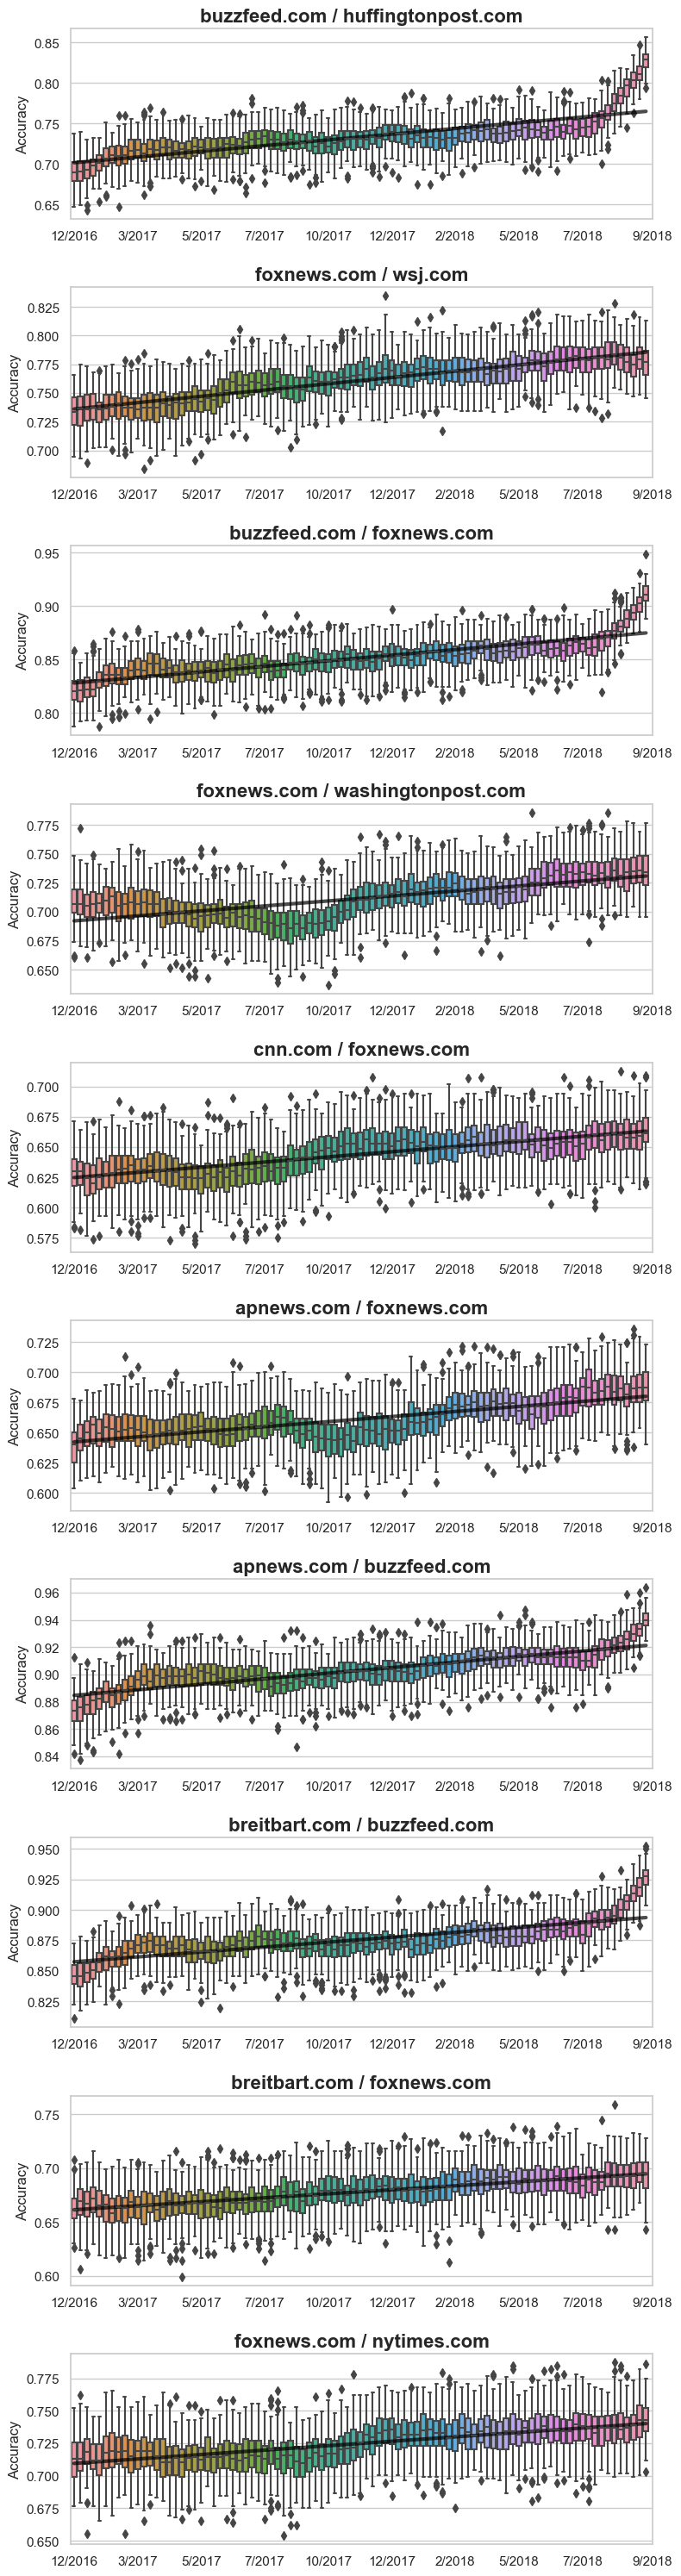

In [15]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

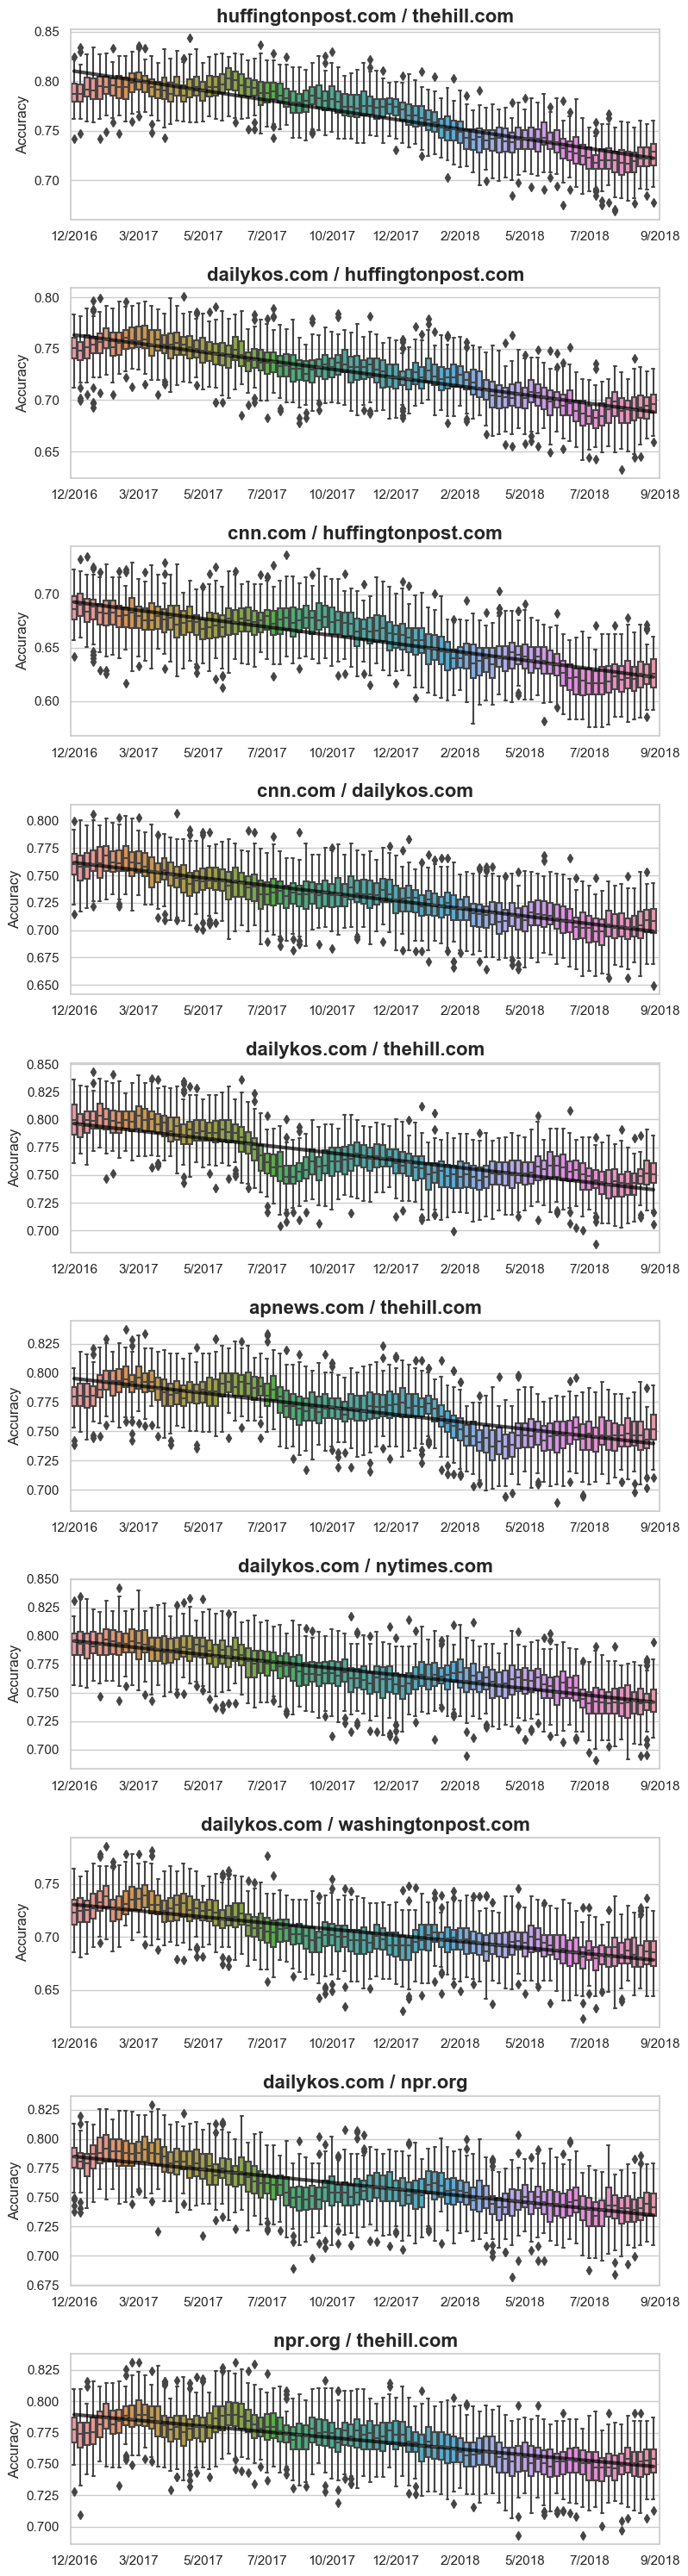

In [16]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [17]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

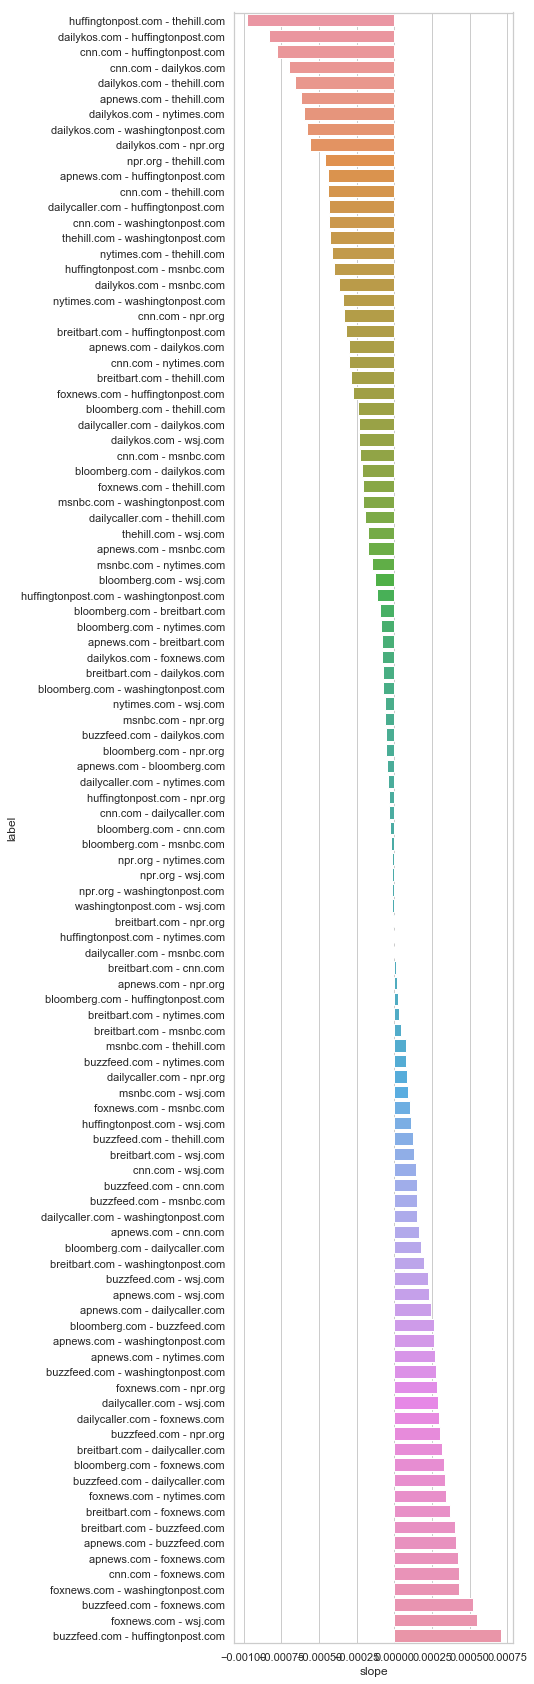

In [18]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [19]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = abs(lr_df.slope*3000)**2

In [20]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [21]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


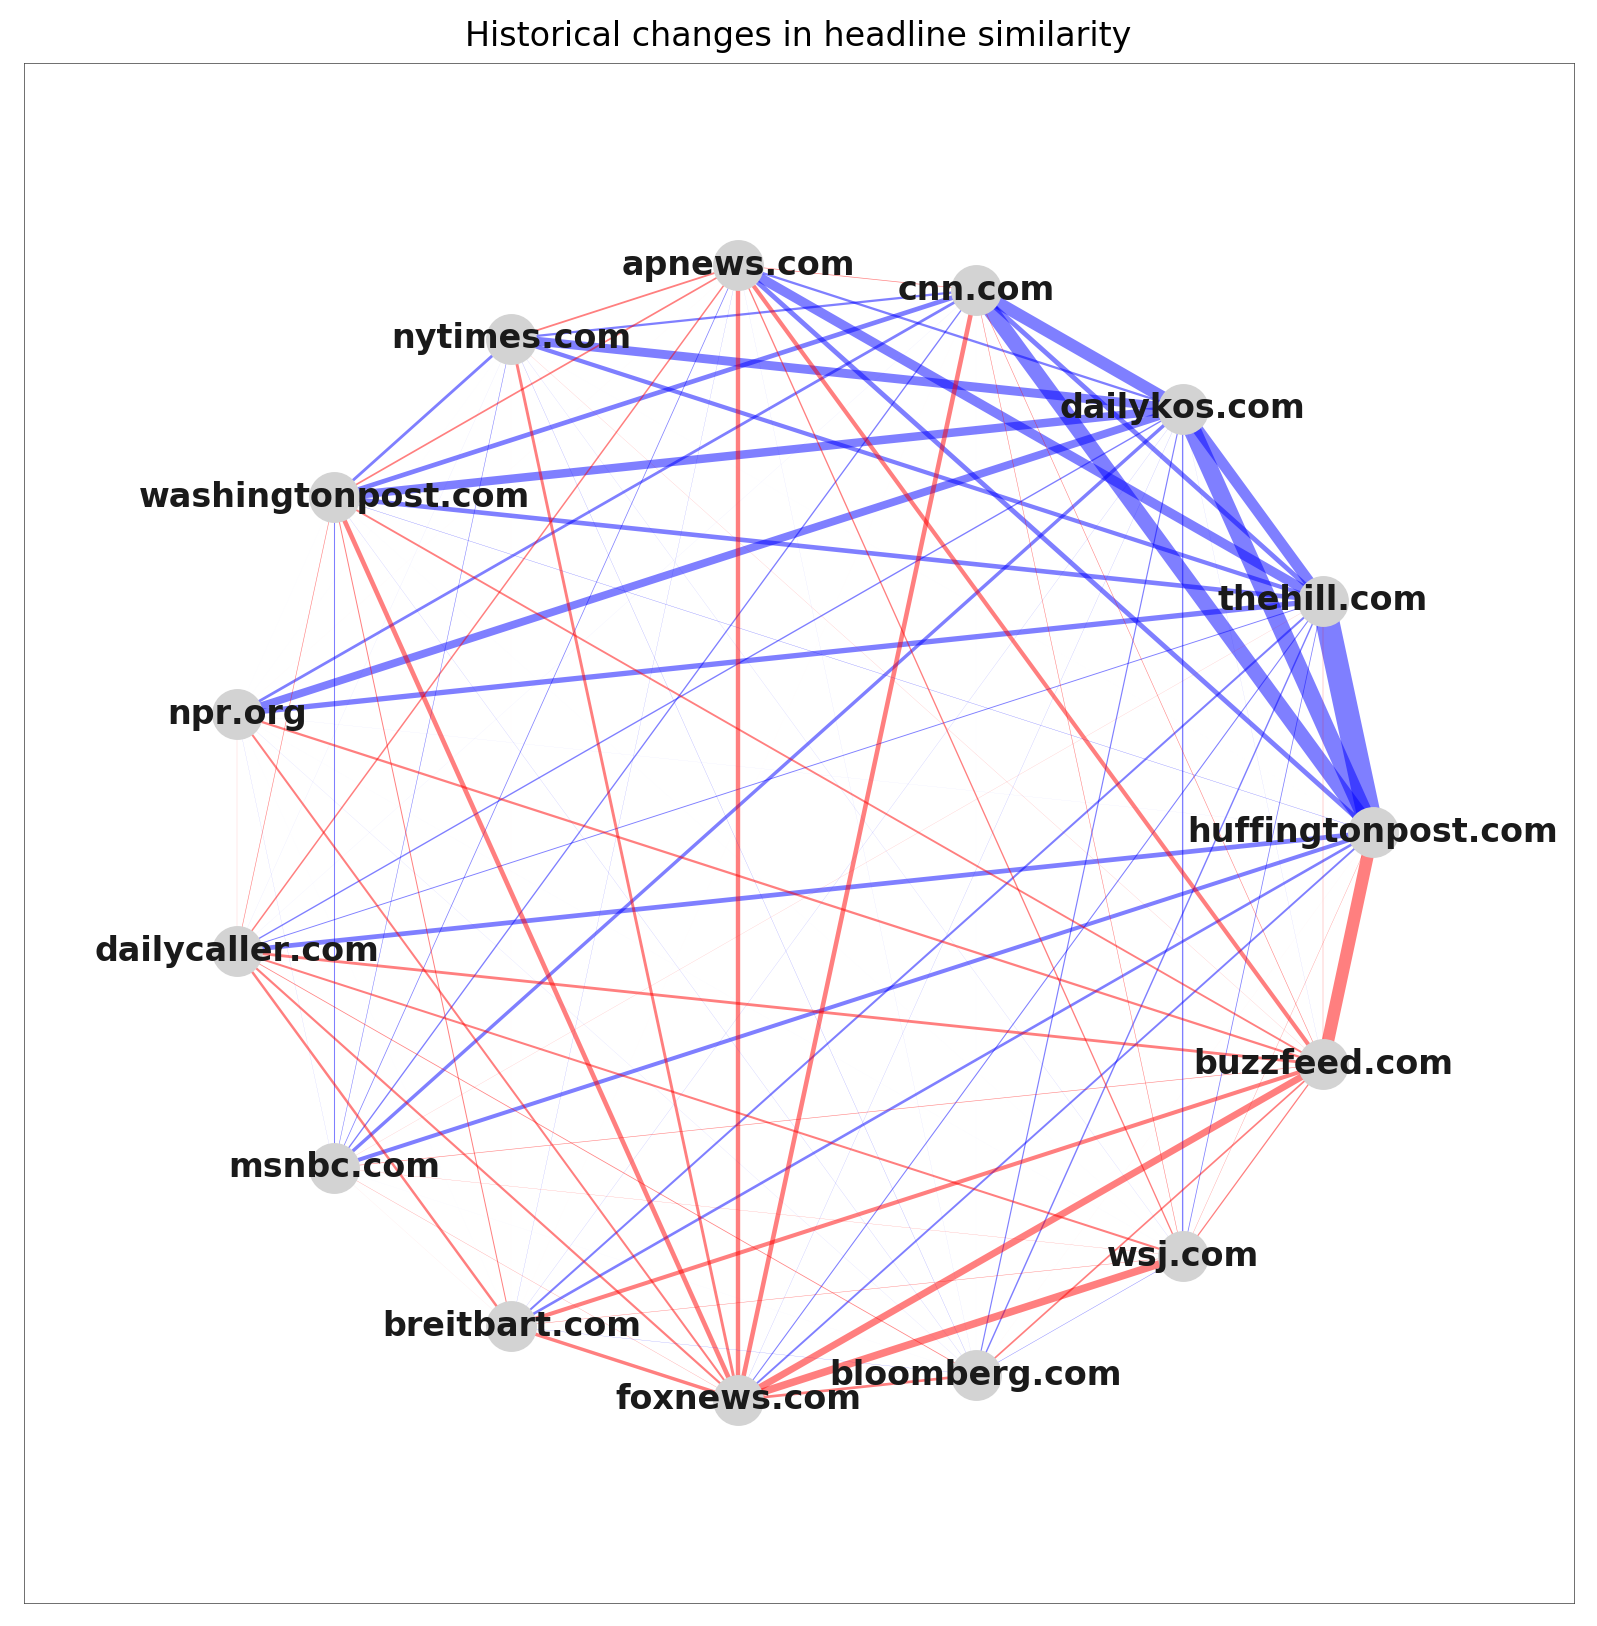

In [35]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [24]:
pred_df, embeds = read_preds('../../data/ava-cnn/')

100%|██████████| 284/284 [00:15<00:00, 18.82it/s]


In [25]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [26]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [27]:
pred_df_start = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) < 10))]
pred_df_end = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) > 80))]

In [28]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in pred_df_start.index:
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in pred_df_end.index:
    idx_end.add_item(i, embeds[i])

In [29]:
idx_start.build(20)
idx_end.build(20)

True

In [45]:
def delta_hls(df1, df2, idx, domain=None, n=20, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(r.title)
            matches += 1
            if matches == n:
                break

# Buzzfeed

In [46]:
delta_hls(
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    idx_end,
    'buzzfeed.com',
)

Build A Trendy Hipster Meal And We 'll Tell You Which YA Heroine You Are
Write A Love Letter And We 'll Tell You Which " To All The Boys " Character You 're Compatible With
Eat A Bunch Of Food And We 'll Tell You Which " SpongeBob " Character You Are
Rate These Movie Theater Snacks And We 'll Reveal If You 'd Survive In A Slasher Film
Make A Break Up Playlist And We 'll Tell You Which Marvel Superhero You 're Most Compatible With
Pick Some Colored Shirts And We 'll Reveal Which " The Breakfast Club " Character You 're Most Like
Make A Breakup Playlist And We 'll Tell You Which Marvel Superhero You 're Most Compatible With
Pick Your First Day Of School Outfit And We 'll Tell You If You 're A Freshman , Sophomore , Junior , Or Senior
Order Some McDonald 's , And We 'll Reveal Whether Your Soulmate Is More Like Jamey Or Peter Kavinsky
Choose Between These Gucci Items And We 'll Tell You Which Disney Princess You Are
See A Movie At The Premiere And We 'll Tell You If You 're More Drake Or 

In [47]:
delta_hls(
    pred_df_end[pred_df_end.domain=='buzzfeed.com'],
    pred_df_start[pred_df_start.domain=='buzzfeed.com'],
    idx_start,
    'buzzfeed.com',
)

Dakota Access Pipeline Challengers Race To Court To Block Construction
Trump Vineyard Seeks More Foreign Workers
Trump Begins Rolling Back Major Obama Water Pollution Rule
Trump Wrote Iraq WMDs Were Threat Year Before Bush Took Office
Trump Winery Seeks Even More Foreign Workers
Alongside Trump , Intel Reannounces Arizona Factory
Trump Moves To Challenge Vaccine Science
Trump Gets Anonymity After Dissing Anonymous Sources
With Tough Re Elections Looming , Democrats Plot Confirmation Hearing Strategy
EPA 's Science Panel Might Soon Be Stacked With Polluters
Tom Steyer Moves Beyond Climate
Guardian Ditches Move To Kushner Building After Newsroom Revolt
NAACP Leaders : Romney Ca n't Connect With Black Audiences
Pentagon " Presenting Options " For Military Action In Syria
20th Century Fox Optioned Bill O'Reilly WWII Book Months Before His Exit
Employers Abuse Foreign Workers . U.S. Says , By All Means , Hire More .
Trump Says Post Crisis Financial Rules Will Be Cut Back
Democrats Confront 

# Fox

In [48]:
delta_hls(
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    idx_end,
    'foxnews.com',
)

Florida female felon 's bloody mugshot the result of her head on crash while fleeing cops , officials say
SC woman allegedly told cops she 's a ' clean , thoroughbred , white girl ' after being pulled over : report
Jefferson Airplane singer Marty Balin sues hospital , claiming he lost part of his tongue after botched tracheotomy
' Smallville ' actress Allison Mack asks court to let her continue acting amid NXIVM sex cult allegations
Charlie Sheen claims he ca n't afford child support after being ' blacklisted ' in Hollywood , says report
Gunman shot by Florida armed bystander still hospitalized , NRA says shooting example of ' good guy with a gun '
' The Wire ' creator David Simon reveals in profanity laced post that he was banned from Twitter after wishing death on Trump supporter
World renowned lesbian NYU professor suspended after probe finds she sexually harassed gay male student , report says
Carter Page was ' more like Inspector Gadget than Jason Bourne , ' Gowdy says amid FISA r

In [49]:
delta_hls(
    pred_df_end[pred_df_end.domain=='foxnews.com'],
    pred_df_start[pred_df_start.domain=='foxnews.com'],
    idx_start,
    'foxnews.com',
)

Trump : No plans to fill ' unnecessary ' appointed positions
Teachers Unions In A Panic Over School Choice
Best job search websites
' Bikepacking ' adds a dose of fun to backpacking
Fox News Poll : Fewer fret over , more focus on politics
Eurozone growth edging higher at the start of second quarter
Is health care a right ?
Five reasons not to observe Lent
Governor of Puerto Rico on debt crisis , push to become state
North Korea : A rare look inside an insulated yet menacing country
Mosquitoes and ticks are coming for us all this summer
Is whiskey becoming less popular ?
CEO gives job applicants a ' snowflake test '
Reformist head of Ukraine 's central bank resigns
Is Zika still a concern ?
OPINION : One Way or Another , Confirm Judge Gorsuch
Trump Starts Over With Tax Plan : Report
Who runs the world ?
Stock it or skip it ? How to cut grocery costs
Agriculture nominee will distance himself from businesses


# NPR -> DK

In [50]:
delta_hls(
    pred_df_start[pred_df_start.domain=='npr.org'],
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    idx_end,
    'npr.org',
)

' I 'm Not A Witch , ' Republican Candidate Christine O'Donnell Tells Delaware Voters
Trump : Democrats ' Un American , ' ' Treasonous ' During State Of The Union
Four Cities ' Lawsuit Calls Trump Efforts To Undermine ' Obamacare ' Unconstitutional
Fact Check : No , James Clapper Did n't ' Admit There Was Spying ' On Trump Campaign
' Enemy Of The People ' : Man Echoing Trump 's Words Charged With Threatening Newspaper
Mitch McConnell On Filling The Federal Bench : ' This Is My Top Priority '
FACT CHECK : Are Democrats Responsible For DHS Separating Children From Their Parents ?
Trump Administration Will Miss Deadline To Reunite Migrant Kids Under 5 With Parents
Alabama 's Roy Moore Sues Over Embarrassing Appearance On Sacha Cohen Series
Ryan : Trump Threat To Revoke Security Clearances Is " Trolling People "
EPA Spent An Extra Million Dollars To Give Scott Pruitt Security
This Jacket Caused A Racket : What , Exactly , Does Melania Trump Not Care About ?
With More Opioid Use , People Ar

In [58]:
delta_hls(
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    pred_df_start[pred_df_start.domain=='npr.org'],
    idx_start,
    'npr.org',
)

Bassist Lyle Ritz : Father of Jazz Ukulele
Du Yun 's ' Angel 's Bone ' Wins Pulitzer Prize For Music
Something 's Fishy At Manaus Airport In Brazil
Art Exhibit Doubles As Used Book Store For Spanish Speakers
Asian Last Names Lead To Fewer Job Interviews , Still
Japan Returns To Top Spot In Sumo Wrestling
Horseshoe Crabs Pile Up For Night Of Whoopee
Juan Felipe Herrera On Poetry In Tough Times
Hear Bonobo 's Moody New Dance Track , ' No Reason '
First Listen : Spoek Mathambo , ' Mzansi Beat Code '
First Listen : Orchestra Baobab , ' Tribute to Ndiouga Dieng '
Do Some Musicians Play Too Well ?
Letters Of Heartbreak Find Some Love In Verona , Italy
WATCH : Time Lapse Video Shows Wall Of Smog In Beijing
Travel Ban Adds Stress To ' Match Week ' For Some Doctors
Welch 's Teams With Manischewitz In Battle Over Kosher Grape Juice
' Selection Day ' Tells Tale Of Cricket Playing Brothers In Mumbai
Webinar : Ear training for audio producers
Watch Big Thief Collaborate On A New Song
Dutch Players 

# CNN -> DK

In [52]:
delta_hls(
    pred_df_start[pred_df_start.domain=='cnn.com'],
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    idx_end,
    'cnn.com',
)

A mayor is assaulted because of his pro immigrant stance . Police are investigating it as a hate crime
Trump appointee resigns as public face of agency that runs AmeriCorps after KFile review of racist , sexist , anti Muslim and anti LGBT comments on the radio
From calling rape ' bad sex ' to Roseanne 's vitriol , this was a jaw dropping week
Only one more state needs to pass the Equal Rights Amendment to finally get it ratified . Here are the 13 that have n't
Trump , comparing sex to Vietnam , said in 1998 he should receive the Congressional Medal of Honor
John Legend calls out Paul Ryan for Father 's Day tweet as immigrant families are being separated
Republicans scramble to understand if Trump just sunk their immigration effort
Stacey Abrams wins Democratic primary in Georgia . She could become the nation 's first black woman governor .
Trump 's executive order is a " temporary solution " because " we 'll run out of space , " White House says
If Trump administration has its way , in

In [57]:
delta_hls(
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    pred_df_start[pred_df_start.domain=='cnn.com'],
    idx_start,
    'cnn.com',
)

F1 : First blood to Ferrari at Australian GP
Barcelona trying to tame tourism crunch
' La La Land ' wins big at BAFTA
India 's child brides for sale - CNN Video
AFCON 2017 : Mahrez 's Algeria on brink of early exit
Snapchat stock soars in Wall Street debut
Souring Iran U.S. relations hang over Boeing 's deal
World 's worst cities for rush hour traffic
Dubai 's smart city ambitions
Oscar predictions : Who will win big ?
Developer behind Word , Excel returns to Microsoft
Love at first sight for Spanish rugby star
Huge iceberg towers over Canadian town
iPads replace cashiers at SF 's quinoa restaurant
South China Sea : Philippines turns down talks
PwC owns up to Oscars flub
US test fires missile to South Pacific - CNN Video
Qatar seals big money horse racing deal
Video shows scene after Sweden attack - CNN Video
Saudi Arabia warns of new crippling cyberattack


# NYT -> DK

In [54]:
delta_hls(
    pred_df_start[pred_df_start.domain=='nytimes.com'],
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    idx_end,
    'nytimes.com',
)

Trump Swears In Gina Haspel as C.I.A. Director , Praising Agency as the ' Most Elite ' in the World
MSNBC Rehires Contributor Sam Seder : ' Sometimes You Just Get One Wrong '
North Korea , Calling Pence Remarks ' Ignorant and Stupid , ' Issues New Warning on Summit
DeSantis Warns Florida Not to ' Monkey This Up , ' and Many Hear a Racist Dog Whistle
Comey , in Interview , Calls Trump ' Morally Unfit ' and ' Stain ' on All Around Him
Leaked Documents From Kavanaugh 's Time in White House Discuss Abortion and Affirmative Action
Should Democrats Have Saved Their Filibuster for the New Court Fight ?
Before White Supremacists ' Rally , Trump Does Not Condemn Them Specifically
' OMG This Is Wrong ! ' Retired English Teacher Marks Up a White House Letter and Sends It Back
Former Trump University Workers Call the School a ' Lie ' and a ' Scheme ' in Testimony
Trump Suggests Mueller Is Trying to Hurt Republicans in Midterms
Opinion | If We Silence Hate Speech , Will We Silence Resistance ?
He '

In [56]:
delta_hls(
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    pred_df_start[pred_df_start.domain=='nytimes.com'],
    idx_start,
    'nytimes.com',
)

Enter a Shikumen Home in Shanghai
A Larger Than Life Caribbean Stew
In Homage to India 's Jewel Culture
A Humble Old Label Ices Its Rivals
Voices From Europe 's Far Right
Who 's Setting Up Shop in Hotels ? Big Name Chefs
' Legion ' Brings a Genuine X Factor to FX
A New Destination for Files Downloaded From Microsoft Edge
Brenna Trout , Avalon Frey
A Millyard Transitions From Textiles to Tech
A Eulogy for Crayola 's Dandelion
Tennis Without Thought , or Backhands
Samsung Leader Is Named a Suspect in South Korean Bribery Inquiry
Giorgio Armani , King of Milan Nightlife
Fewer Teenagers Are Poised to Join Top Ranks of Tennis
A Small Table Maker Takes On Alibaba 's Flood of Fakes
A Tour of Rodrigo Corral 's Manhattan Workspace
Documenta 14 , a German Art Show 's Greek Revival
Heng on U.S. Ties with Japan
Cartier Courts Young Men With Luxe Watches


# WaPo -> DK

In [59]:
delta_hls(
    pred_df_start[pred_df_start.domain=='washingtonpost.com'],
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    idx_end,
    'washingtonpost.com',
)

Analysis | The Health 202 : House Republicans move to indefinitely detain migrant kids with families
' I will not back down ' : Kansas Republican defends displaying replica machine gun in parade
Rachel Maddow breaks down in tears on air while reading report on ' tender age ' shelters
Perspective | Angry that ICE is ripping families apart ? Do n't just blame Trump . Blame Clinton , Bush and Obama , too .
Migrant parents were misled into waiving rights to family reunification , ACLU tells court
White House to Senate Democrats : Time running out on meeting with Kavanaugh
Analysis | Half of Republicans approve of Trump undermining the intelligence community while standing with Putin
Congressional , state investigations into Planned Parenthood underway after undercover video goes viral
Opinion | Another hurricane is about to batter our coast . Trump is complicit .
Opinion | Supreme Court unanimously reaffirms : There is no ' hate speech ' exception to the First Amendment
Opinion | Angry abo

In [60]:
delta_hls(
    pred_df_end[pred_df_end.domain=='dailykos.com'],
    pred_df_start[pred_df_start.domain=='washingtonpost.com'],
    idx_start,
    'washingtonpost.com',
)

GM sells European brands to France 's Peugeot
What life is like living with a ' love doll ' in Japan
Erdem 's full length dresses mesmerize at London Fashion Week
Accounts of girl raised by monkeys in India questioned
Girls ' soccer Top 10 : Woodgrove uses all 21 of its players , embraces a sub heavy approach
Analysis | As Scotland relaunches its independence bid , Catalonia has its own plan
A German court has shut down hopes for a breakaway Bavaria
Once underfed , Brazil 's poor have a new problem : obesity
Hundreds of Tibetans defy China , gather at birthplace of Buddhism in India
Chuck Wielgus , sports executive who elevated U.S. swimming , dies at 67
Opinion | France 's future depends on one question — and one man
McDevitt quits as head of Australia 's anti doping agency
Seoul court considers arrest of Samsung de facto head
Analysis | The United States might be the next Argentina
A Japanese artist takes on a country that despises tattoos
Smart home model integrates Amazon 's Alexa 